The following code load optimized deep convoluational neural network model for explainability analysis ('model_for_Xgrad.pth') for angle 1 and perform explainability analysis for sample 3D-surface images in a directory for the samples ('./sample_data/') based on Xgrad algorithm.

In [38]:
# -*- coding: utf-8 -*-
#import modules
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision.models import *
from torchvision import transforms, datasets
import torchvision.transforms as transforms
from torch.utils.data.dataset import Subset
#import torchvision.models as models
from torchvision.utils import make_grid, save_image
from torchvision.transforms.functional import normalize, resize, to_pil_image
from torchcam.utils import overlay_mask
from torchcam.methods import XGradCAM

import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
%matplotlib inline
#import time
import cv2
import os
#import copy
import numpy as np
import glob


In [39]:
#import model for explainability analysis
model_constructor = getattr(torchvision.models, 'resnet18')
model_ft = model_constructor(num_classes=3)
target_layers = model_ft.layer4
model_ft.load_state_dict(torch.load('model_for_Xgrad.pth', map_location="cpu"))
model = model_ft.eval()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

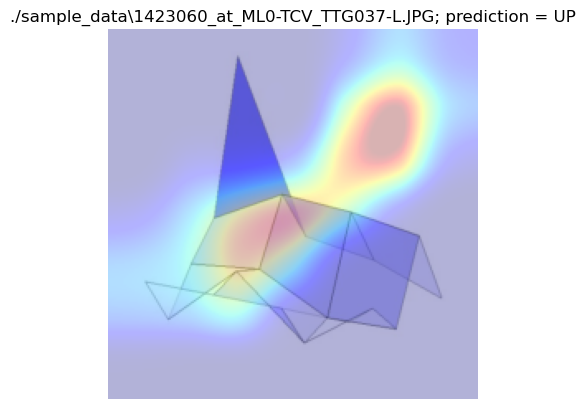

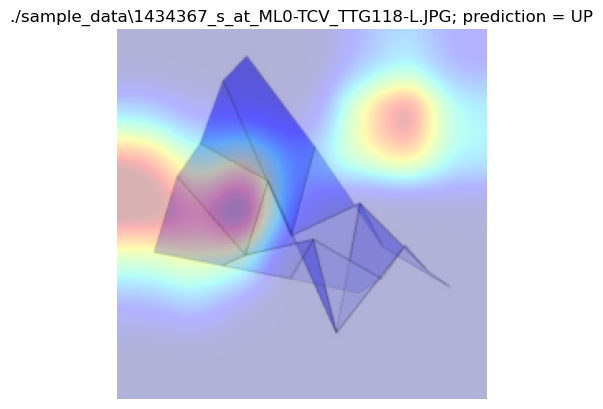

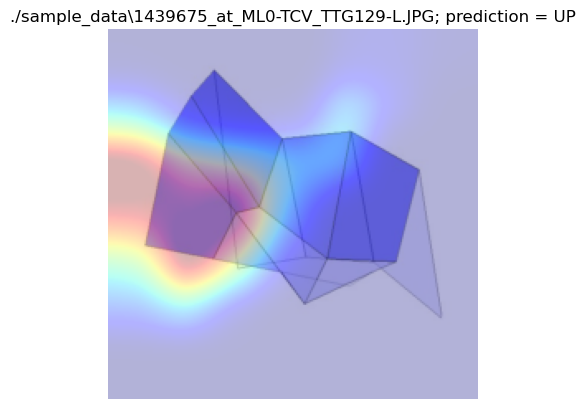

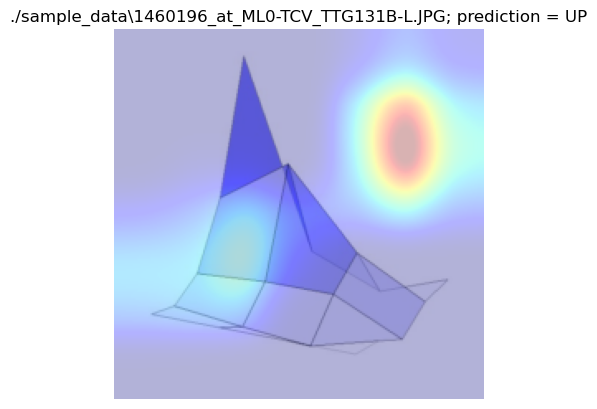

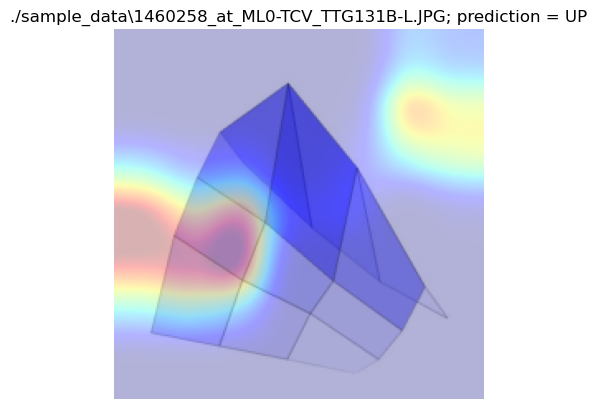

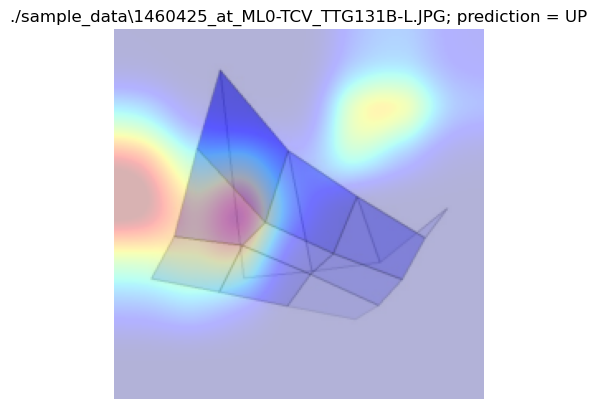

In [40]:
#list up input image files wthinin a directory (in this case, ./sample_data/).
i = glob.glob("./sample_data/*.jpg")

#run explainability analysis for 3D-surface images based on XGrad algorithm.
cam_extractor = XGradCAM(model, 'layer4')
for f in i:
   img = Image.open(f).convert('RGB')
   torch_img = transforms.Compose([
           transforms.Resize((224, 224)),
           transforms.ToTensor()
       ])(img).to("cpu")
   out = model(torch_img.unsqueeze(0))
   _, prediction = torch.max(out, 1)
   if prediction.cpu().numpy()[0] == 0:
      clas = "DOWN"
   elif prediction.cpu().numpy()[0] == 1:
      clas = "NS"
   elif prediction.cpu().numpy()[0] == 2:
      clas = "UP"
   cams = cam_extractor(out.squeeze(0).argmax().item(), out)
   for name, cam in zip(cam_extractor.target_names, cams):
     result = overlay_mask(to_pil_image(torch_img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.7)
     plt.imshow(result); plt.axis('off'); plt.title(f + "; prediction = " + clas); plt.show()
   #uncomment following lines to save 3D-surface images with explainability analysis.
   #file_res = f.split("\\")[1] + ".png"
   #result.save(file_res)